In [1]:
%load_ext autoreload
%autoreload 2

# imports


In [2]:
from itertools import product
from copy import copy
from matplotlib.collections import PathCollection
from collections import namedtuple
import numpy as np
import pandas as pd
import warnings
import seaborn as sns
import pickle
from matplotlib.colors import LogNorm
from matplotlib.gridspec import GridSpec
from scipy.optimize import fmin_l_bfgs_b
from scipy.special import erfinv
from scipy.stats import chi2

from fluxes import atmo_background, astro_flux
from aeff_calculations import calc_aeff_factor
from settings import ngc1068
from tools import get_mids
from scipy.interpolate import RegularGridInterpolator

BASEPATH = "/home/lisajsch/notebooks/Plenum/"
from os.path import join
matplotlib = sns.mpl
plt = matplotlib.pyplot
plt.style.use(join(BASEPATH, "style.mplstyle"))
warnings.filterwarnings("ignore")

# Idea

* Livetime scaling (=aeff scaling)
* Energy resolution scaling
* Angular resolution scaling

-> Discovery potential / Significance scaling

# loading effective areas


In [3]:
sindec_bins, logE_bins, aeffs = pd.read_pickle(join(BASEPATH, "resources/aeff_cluster_nuecc_with-eq.pickle"))


## binning

In [4]:
aeff_test = aeffs.iloc[0]["equatorial_fine"] # for testing
logE_mids = get_mids(logE_bins)
ebins = np.power(10, logE_bins)
emids = get_mids(ebins)
ewidth = np.diff(ebins)
sindec_mids = get_mids(sindec_bins)
sindec_width = np.diff(sindec_bins)

print(len(emids), "log_10(energy) bins")
print(len(sindec_mids), "declination bins")

90 log_10(energy) bins
100 declination bins


# background

In [5]:
# MCEQ
with open(join(BASEPATH, "resources/MCEq_flux.pckl"), "rb") as f:
    (e_grid, zen), bg_flux_def = pickle.load(f)
# load total nue+nuebar + nutau+nutaubar
# (nutau+nutaubar is practically zero)
rgi = RegularGridInterpolator(
    (e_grid, -np.cos(np.deg2rad(zen))), np.log(bg_flux_def["nue_total"] + bg_flux_def["nutau_pr"])
)
ee, ss = np.meshgrid(emids, sindec_mids)
spl_vals = np.exp(rgi((ee, ss)))

# astro flux source parameters

In [6]:
# livetime of 10yr in seconds
LIVETIME = 365 * 10 * 24 * 3600
# diffuse flux
from aeff_calculations import aeff_eval_e_sd
from settings import E_NORM, PHI_ASTRO, GAMMA_ASTRO
PHI_ASTRO *= 2 # two flavors (nue + nutau equal mixing)

print(PHI_ASTRO)
print(GAMMA_ASTRO)


2.88e-18
2.37


In [7]:
diff_config = {
    "diff_or_ps": "diff",
    "sindec_width": sindec_width,
    "ewidth": ewidth,
    "livetime": LIVETIME

}

# Flux definition

In [8]:
# we base the flux models on named-tuples
PL_flux = namedtuple("PL_flux", "norm gamma E0 shape")
PLcut_flux = namedtuple("PLcut_flux", "norm gamma e_cut E0 shape")
LogP_flux = namedtuple("LogP_flux", "norm alpha beta E0 shape")

flux_collection = {
    "powerlaw": PL_flux,
    "powerlaw with cutoff": PLcut_flux,
    "log-parabola": LogP_flux,
}

# generic astro diffuse flux
flux_def = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")


# simple diffuse fit

## energy and sindec resolution

In [9]:
resolution_df = pd.read_pickle(
    join(BASEPATH, "resources/optimization_resolutions_energy.pickle")
)
resolution_df = resolution_df.set_index(["config", "spacing", "pmts"])


## llh definition

In [10]:
def diffuse_llh_2d_composite(
    x,
    mu_b_base,
    mu_s_base,
    k_i,
    e_0,
    phi_0,
    shape,
    normed_kvals,
    spl_vals=spl_vals,
    plot_this=False,
    ereco=None, #only for plotting
):
    """fit parameters in x:
    for the standard power law:
    x[0]: background normalization scaling
    x[1]: signal normalization scaling
    x[2]: signal spectral index

    see 'astro_flux' for further shapes and parameters

    mu_b_base: effective area factor
    mu_s_base: effective area factor for signal
    k_i: observation/asimov data
    e_norm: normalization energy, default E0_NGC
    phi_0: normalization flux, default PHI_NGC
    shape: flux shape, default 'powerlaw'
    """

    mu_b = atmo_background(
        mu_b_base * x[0],
        spl_vals,
        normed_kvals=normed_kvals,
    )
    mu_s = astro_flux(
        mu_s_base,
        emids,
        normed_kvals,
        x[1],
        flux_collection[shape](
            phi_0, *x[2:], e_0, shape
        ),  # here we generate a flux tuple with the current parameters
    )
    mu_i = mu_s + mu_b
    if plot_this:
        print(np.shape(ereco), np.shape(mu_s), np.shape(mu_s.sum(axis=0)))
        f, axes = plt.subplots(ncols=2, figsize=(12, 6))
        axes[0].plot(
            ereco, mu_s.sum(axis=0), ls="-", label="mu_s", ds="steps-mid"
        )
        axes[0].plot(
            ereco, mu_b.sum(axis=0), ls="--", label="mu_b", ds="steps-mid"
        )
        axes[0].set_yscale("log")
        axes[0].legend()
        axes[0].set_title("ereco from llh function")

        sdm = np.linspace(-1, 1, len(mu_s))
        axes[1].plot(sdm, mu_s.sum(axis=1), ls="-", label="mu_s", ds="steps-mid")
        axes[1].plot(sdm, mu_b.sum(axis=1), ls="--", label="mu_b", ds="steps-mid")
        axes[1].set_title("sindec from llh function")

    return -2 * np.sum(
        np.where(
            np.logical_and(mu_i > 0, k_i > 0),
            k_i * np.log(mu_i)
            - mu_i
            - 0.5 * np.log(2 * np.pi * k_i)
            + k_i
            - k_i * np.log(k_i),
            0,
        )
    )


# diffuse vs uniform atmospheric

## Angular resolution scaling

see also cascade_optimization_input.ipynb

In [11]:
from scipy.stats import norm

In [12]:
fisher = pd.read_pickle(join(BASEPATH, "resources/fisher_casc.pickle"))
# give a name to the first index
fisher.index.names = ['config', 'spacing', 'energy', 'pmts']
logE_reco_bins = np.copy(logE_bins)

In [49]:
# mask
ident = ("Full pessimistic cluster", 110, slice(None), 16)
series = fisher.loc[ident]

eres_scaling = np.logspace(0, 1, num=20)

true_E = series.index.get_level_values(0).values
width_E = series.logE.values
width_E_floor = 0.05 / np.log(10)

# interpolate
## energy width
mask = np.isfinite(width_E)
fit_we = np.poly1d(np.polyfit(np.log10(true_E[mask]), np.log10(width_E[mask]), 1))

pdlist_energy = []
for ii, esc in enumerate(eres_scaling):
    dct = {"eres_scaling": esc}
    # energy resolution
    eres_all = []
    for et in logE_mids:
        if 10 ** fit_we(et) <= width_E_floor:
            tmp = width_E_floor
        else:
            # apply energy scaling
            tmp = esc * 10 ** fit_we(et)
        # integrate over bin
        eres = norm.cdf(logE_reco_bins[1:], loc=et, scale=tmp) - norm.cdf(
            logE_reco_bins[:-1], loc=et, scale=tmp
        )
        eres_all.append(eres / np.sum(eres))
    eres_all = np.array(eres_all).T
    dct["energy_res"] = eres_all
    if False:
        plt.figure()
        plt.pcolormesh(eres_all)
        plt.show()
    pdlist_energy.append(dct)
energy_resolution = pd.DataFrame(pdlist_energy)

energy_resolution = energy_resolution.set_index("eres_scaling")

In [50]:
c_names = np.asarray(aeffs.index.names)
mask = (
    (aeffs.index.get_level_values("spacing") == 110)
    & (aeffs.index.get_level_values("module_threshold") == 3)
    & (aeffs.index.get_level_values("hit_threshold") == 3)
)
flux_def = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")

full_det = False
diff_significances = []
flux_scalings = np.logspace(-0.5, 1, num=20)

for esc, flux_scale, (config, aeff) in product(eres_scaling, flux_scalings, aeffs.loc[mask].iterrows()):
    if full_det:
        aeff *= 7  # full detector
    tmp = {key: val for key, val in zip(c_names, config)}
    aeff_test = aeff["equatorial_fine"]
    reso_test = energy_resolution.loc[esc]
    aeff_factor = calc_aeff_factor(aeff_test, **diff_config)
    k_s = astro_flux(
        aeff_factor,
        emids,
        normed_kvals=reso_test.energy_res,
        phi_scaling=flux_scale,
        flux_shape=flux_def,
    )

    k_b = atmo_background(
        aeff_factor,
        spl_vals,
        normed_kvals=reso_test.energy_res,
    )

    mu_base = np.copy(aeff_factor)
    k_i = k_s + k_b

    tmp["nb"] = np.sum(k_b)
    tmp["ns"] = np.sum(k_s)
    tmp["flux_scale"] = flux_scale
    tmp["eres_scaling"] = esc

    fit_config = dict(
        mu_b_base=aeff_factor,
        mu_s_base=aeff_factor,
        k_i=k_i,
        e_0=E_NORM,
        phi_0=PHI_ASTRO,
        shape="powerlaw",
        normed_kvals=reso_test.energy_res,
    )
    # fix signal contribution to 0
    local_llh = lambda x: diffuse_llh_2d_composite((x[0], 0, 2), **fit_config)
    global_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.1,),
        bounds=[(1e-3, 1e2)],
        approx_grad=True,
    )
    # tmp["bg_atmo_norm"] = out_bckg[0][0]

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.0, 1.0, 2.3),
        bounds=[(1e-3, 1e2), (1e-3, 1e2), (1.5, 3.5)],
        approx_grad=True,
        factr=10,
    )

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = erfinv(1 - pval) * np.sqrt(2)
    tmp["pval"] = pval
    tmp["sigma"] = significance
    diff_significances.append(tmp)

diff_significances = pd.DataFrame(diff_significances)

diff_significances["sigma_cut"] = 7
diff_significances.loc[
    diff_significances["sigma"] <= 7, "sigma_cut"
] = diff_significances.loc[diff_significances["sigma"] <= 7, "sigma"]
add = "full" if full_det else "cluster"
pd.to_pickle(
    diff_significances,
    join(
        BASEPATH,
        f"resources/casc_diffuse_significance_{add}_gamma-{flux_def.gamma}_escaling_DP.pckl",
    ),
)


### plotting

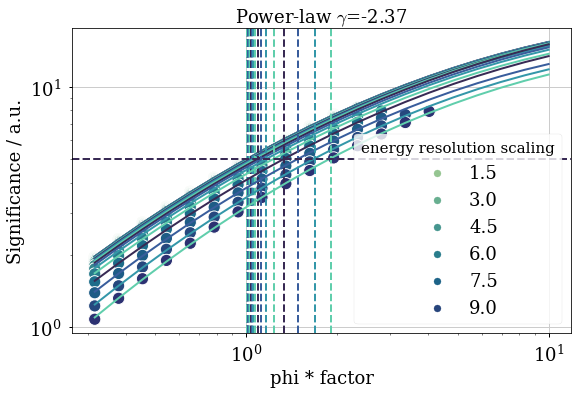

In [51]:
diff_significances_cluster = pd.read_pickle(
    join(BASEPATH, f"resources/casc_diffuse_significance_cluster_gamma-{flux_def.gamma}_escaling_DP.pckl")
)

selection = diff_significances_cluster.loc[
    (diff_significances_cluster.hit_threshold >= 3)
    & (diff_significances_cluster.module_threshold >= 3)
    & (diff_significances_cluster.spacing == 110)
]

f, ax = plt.subplots()
ncols = len(selection.module_threshold.unique())
condition = (selection.min_pos_resolution.isna()) & (selection.hit_threshold == 3)

ax = sns.scatterplot(
    data=selection.loc[condition],
    y="sigma",
    x="flux_scale",
    hue="eres_scaling",
    palette="crest",
    ax=ax,
    s=150,
)

# get scatterblobs to extract color (black magic)
blobs = [r for r in ax.get_children() if type(r)==PathCollection]

lg = ax.get_legend()

# for lh in lg.legendHandles:
#     lh._sizes = [150]
lg.set_title("energy resolution scaling")
title = lg.get_title()
title.set_fontsize(15)


# make a fit to livetime scaling
# log10(sigma) = c1 log10(lt)^2 + c2 log10(lt) + c3
i=1
DPs = []
for lt, series in selection.loc[condition].groupby("eres_scaling"):
    mask = np.isfinite(series.sigma)
    func = np.poly1d(
        np.polyfit(
            np.log10(series[mask].flux_scale),
            np.log10(series[mask].sigma),
            2,
        )
    )

    func_inv = np.poly1d(
        np.polyfit(
            np.log10(series[mask].sigma),
            np.log10(series[mask].flux_scale),
            2,
        )
    )

    sigma5_DP = 10**func_inv(np.log10(5))
    p = ax.plot(flux_scalings, 10**func(np.log10(flux_scalings))) #, color=blobs[i].get_facecolor())
    ax.axvline(sigma5_DP, color=p[0].get_color(), ls="--")
    DPs.append(sigma5_DP)
    i += 1

ax.set_ylabel(r"Significance / a.u.")
ax.set_xlabel("phi * factor")
ax.set_title(rf"Power-law $\gamma$=-{flux_def.gamma}")

f.tight_layout()
# f.savefig(join(BASEPATH, "plots/cascades_diff_significances.png"))

ax.loglog()
ax.axhline(5, ls="--")


         2
0.01364 x - 0.0523 x + 1.062


Text(0.5, 1.0, 'Diffuse flux discovery potential (10-Str cluster)')

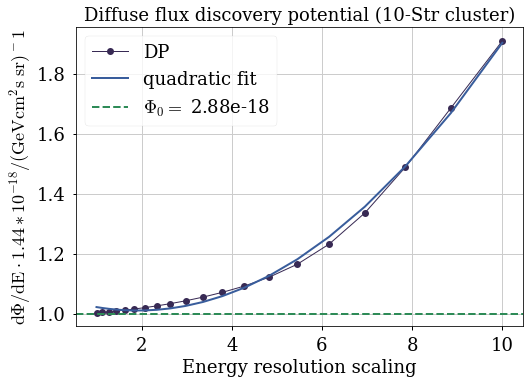

In [52]:
DPs = np.array(DPs)
f, ax = plt.subplots()
ax.plot(eres_scaling, DPs, lw=1, marker="o", label="DP")
ax.set_ylabel(r"${\rm d\Phi/dE \cdot 1.44 * 10^{-18} /( GeV cm^2 s\ sr)^-1}$")
ax.set_xlabel("Energy resolution scaling")
# ax.set_xlim(1)
fit_func = np.poly1d(np.polyfit(eres_scaling, DPs, 2))
print(fit_func)

ax.plot(
    eres_scaling, fit_func(eres_scaling), label="quadratic fit"
)
ax.axhline(
    1,
    label=rf"$\Phi_0 =$ {flux_def.norm:1.2e}",
    ls="--",
    color="seagreen",
)
ax.legend()
# ax.semilogy()
# ax.semilogx()
ax.set_title("Diffuse flux discovery potential (10-Str cluster)")


## Livetime scaling

In [ ]:
c_names = np.asarray(aeffs.index.names)
mask = (
    (aeffs.index.get_level_values("spacing") == 110)
    & (aeffs.index.get_level_values("module_threshold") == 3)
    & (aeffs.index.get_level_values("hit_threshold") == 3)
)
flux_def = PL_flux(PHI_ASTRO, GAMMA_ASTRO, E_NORM, "powerlaw")

full_det = False
diff_significances = []
flux_scalings = np.logspace(-0.5, 1, num=20)
livetimes = np.logspace(0, 1.7, num=20)
current_config = copy(diff_config)


In [12]:
for livetime, flux_scale, (config, aeff) in product(livetimes, flux_scalings, aeffs.loc[mask].iterrows()):
    current_config["livetime"] = livetime * 3600 * 24 * 365
    if full_det:
        aeff *= 7  # full detector
    tmp = {key: val for key, val in zip(c_names, config)}
    aeff_test = aeff["equatorial_fine"]
    reso_test = resolution_df.loc["Full pessimistic cluster", config[-1], 16]
    aeff_factor = calc_aeff_factor(aeff_test, **current_config)
    k_s = astro_flux(
        aeff_factor,
        emids,
        normed_kvals=reso_test.energy_res,
        phi_scaling=flux_scale,
        flux_shape=flux_def,
    )

    k_b = atmo_background(
        aeff_factor,
        spl_vals,
        normed_kvals=reso_test.energy_res,
    )

    mu_base = np.copy(aeff_factor)
    k_i = k_s + k_b

    tmp["nb"] = np.sum(k_b)
    tmp["ns"] = np.sum(k_s)
    tmp["flux_scale"] = flux_scale
    tmp["livetime"] = livetime

    fit_config = dict(
        mu_b_base=aeff_factor,
        mu_s_base=aeff_factor,
        k_i=k_i,
        e_0=E_NORM,
        phi_0=PHI_ASTRO,
        shape="powerlaw",
        normed_kvals=reso_test.energy_res,
    )
    # fix signal contribution to 0
    local_llh = lambda x: diffuse_llh_2d_composite((x[0], 0, 2), **fit_config)
    global_llh = lambda x: diffuse_llh_2d_composite(x, **fit_config)
    out_bckg = fmin_l_bfgs_b(
        local_llh,
        x0=(1.1,),
        bounds=[(1e-3, 1e2)],
        approx_grad=True,
    )
    tmp["bg_atmo_norm"] = out_bckg[0][0]

    out_comp = fmin_l_bfgs_b(
        global_llh,
        x0=(1.0, 1.0, 2.3),
        bounds=[(1e-3, 1e2), (1e-3, 1e2), (1.5, 3.5)],
        approx_grad=True,
        factr=10,
    )
    tmp["status"] = out_comp[2]["warnflag"]
    tmp["comb_atmo_norm"] = out_comp[0][0]
    tmp["comb_astro_norm"] = out_comp[0][1]
    tmp["comb_astro_gamma"] = out_comp[0][2]
    tmp["-2DLLH"] = out_bckg[1] - out_comp[1]
    tmp["bg_TS"] = out_bckg[1]
    tmp["comb_TS"] = out_comp[1]
    tmp["check_TS"] = global_llh((1, 1, GAMMA_ASTRO))

    pval = chi2.sf(out_bckg[1] - out_comp[1], 2)
    significance = erfinv(1 - pval) * np.sqrt(2)
    tmp["pval"] = pval
    tmp["sigma"] = significance
    tmp["check_sigma"] = erfinv(
        1 - chi2.sf(out_bckg[1] - tmp["check_TS"], 2)
    ) * np.sqrt(2)
    diff_significances.append(tmp)

diff_significances = pd.DataFrame(diff_significances)

diff_significances["sigma_cut"] = 7
diff_significances.loc[
    diff_significances["sigma"] <= 7, "sigma_cut"
] = diff_significances.loc[diff_significances["sigma"] <= 7, "sigma"]
add = "full" if full_det else "cluster"
pd.to_pickle(
    diff_significances,
    join(
        BASEPATH,
        f"resources/casc_diffuse_significance_{add}_gamma-{flux_def.gamma}_DP.pckl",
    ),
)


### plotting

In [13]:
diff_significances_cluster = pd.read_pickle(
    join(BASEPATH, f"resources/casc_diffuse_significance_cluster_gamma-{flux_def.gamma}_DP.pckl")
)

selection = diff_significances_cluster.loc[
    (diff_significances_cluster.hit_threshold >= 3)
    & (diff_significances_cluster.module_threshold >= 3)
    & (diff_significances_cluster.spacing == 110)
]

f, ax = plt.subplots()
ncols = len(selection.module_threshold.unique())

condition = (selection.min_pos_resolution.isna()) & (selection.hit_threshold == 3)

ax = sns.scatterplot(
    data=selection.loc[condition],
    y="sigma",
    x="flux_scale",
    hue="livetime",
    #hue="module_threshold",
    #style="hit_threshold",
    palette="crest",
    ax=ax,
    s=150,
)
# get scatterblobs to extract color (black magic)
blobs = [r for r in ax.get_children() if type(r)==PathCollection]

lg = ax.get_legend()

# for lh in lg.legendHandles:
#     lh._sizes = [150]
lg.set_title("Livetime / yr")
title = lg.get_title()
title.set_fontsize(15)


# make a fit to livetime scaling
# log10(sigma) = c1 log10(lt)^2 + c2 log10(lt) + c3
i=1
DPs = []
for lt, series in selection.loc[condition].groupby("livetime"):
    mask = np.isfinite(series.sigma)
    func = np.poly1d(
        np.polyfit(
            np.log10(series[mask].flux_scale),
            np.log10(series[mask].sigma),
            2,
        )
    )

    func_inv = np.poly1d(
        np.polyfit(
            np.log10(series[mask].sigma),
            np.log10(series[mask].flux_scale),
            2,
        )
    )

    sigma5_DP = 10**func_inv(np.log10(5))
    p = ax.plot(flux_scalings, 10**func(np.log10(flux_scalings))) #, color=blobs[i].get_facecolor())
    ax.axvline(sigma5_DP, color=p[0].get_color(), ls="--")
    DPs.append(sigma5_DP)
    i += 1

ax.set_ylabel(r"Significance / a.u.")
ax.set_xlabel("phi * factor")
ax.set_title(rf"Power-law $\gamma$=-{flux_def.gamma}")

f.tight_layout()
# f.savefig(join(BASEPATH, "plots/cascades_diff_significances.png"))

ax.loglog()
ax.axhline(5, ls="--")


 
-0.8232 x + 0.8468


Text(0.5, 1.0, 'Diffuse flux discovery potential (10-Str cluster)')

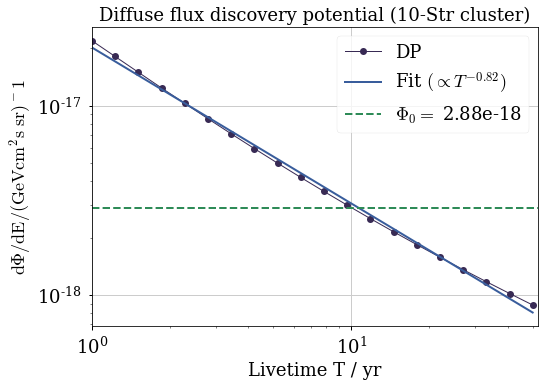

In [15]:
DPs = np.array(DPs)
f, ax = plt.subplots()
ax.plot(livetimes, DPs * flux_def.norm, lw=1, marker="o", label="DP")
ax.set_ylabel(r"${\rm d\Phi/dE /( GeV cm^2 s\ sr)^-1}$")
ax.set_xlabel("Livetime T / yr")
ax.set_xlim(1)
fit_func = np.poly1d(np.polyfit(np.log10(livetimes), np.log10(DPs), 1))
print(fit_func)
lts = np.linspace(1, 50)
ax.plot(lts, 10**fit_func(np.log10(lts)) * flux_def.norm, label=fr"Fit $(\propto T^{{{fit_func.coef[0]:1.2f}}})$")
ax.axhline(flux_def.norm, label=fr"$\Phi_0 =$ {flux_def.norm:1.2e}", ls="--", color="seagreen")
ax.legend()
ax.loglog()
ax.set_title("Diffuse flux discovery potential (10-Str cluster)")

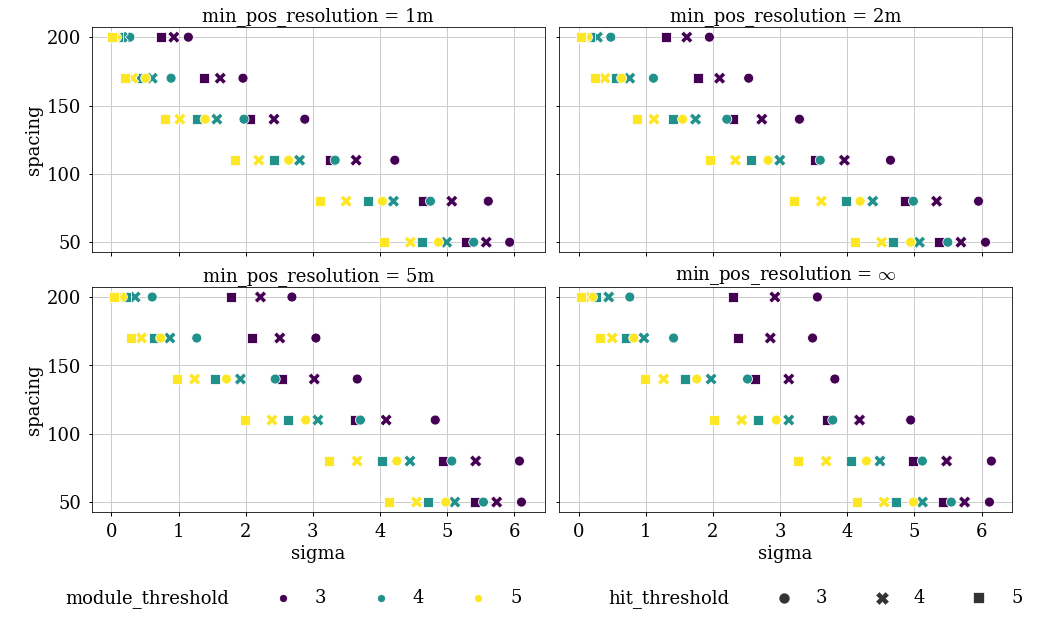

In [ ]:
f, axes = plt.subplots(figsize=(14, 8), ncols=2, nrows=2, sharex=True, sharey=True)
ncols = len(selection.module_threshold.unique())

condition = [
    ("min_pos_resolution = 1m", selection.min_pos_resolution == 1),
    ("min_pos_resolution = 2m", selection.min_pos_resolution == 2),
    ("min_pos_resolution = 5m", selection.min_pos_resolution == 5),
    (r"min_pos_resolution = $\infty$", selection.min_pos_resolution.isna()),
]


for ii, ax in enumerate(axes.flatten()):

    ax = sns.scatterplot(
        data=selection.loc[condition[ii][1]],
        x="sigma",
        y="spacing",
        hue="module_threshold",
        style="hit_threshold",
        size="hit_threshold",
        sizes=(100, 200),
        palette="viridis",
        ax=ax,
    )
    #ax.set_xscale("log")
    ax.set_title(condition[ii][0])

    if ii==0:
        f.legend(
        ncol=8, loc="upper center", bbox_to_anchor=(0.5, 0.0), frameon=False, fontsize=18
    )
    ax.legend([], frameon=False)


f.tight_layout()
f.savefig(join(BASEPATH, f"plots/cascades_diff_significances_gamma-{flux_def.gamma}.png"))
